<a href="https://colab.research.google.com/github/yashwanth-nadella/network_intrusion_detection_system/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection Systems using Machine Learning

## Reading the data sets and Initial Exploration
Let's begin with importing the necessary modules.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools
import random

from warnings import filterwarnings
filterwarnings('ignore')

Note that the '.txt' files are stored in CSV format.

In [ ]:
col_names = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])


train = pd.read_csv('/content/drive/MyDrive/Datasets/KDDTrain+.txt', header=None,names=col_names)
test = pd.read_csv('/content/drive/MyDrive/Datasets/KDDTest+.txt', header=None,names=col_names)
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
# map normal to 0, all attacks to 1
is_attack = train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
train['attack_flag'] = is_attack
test['attack_flag'] = test_attack

# view the result
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


Next, we'll classify each of the attacks according to attack type for a more granular prediction model.

1) Denial of Service attacks: apache2,back,land, neptune, mailbomb, pod, processtable, smurf, teardrop, udpstorm, worm

2) Probe attacks: ipsweep, mscan, nmap, portsweep, saint, satan

3) Privilege escalation attacks: buffer_overflow, loadmdoule, perl, ps, rootkit, sqlattack, xterm

4) Remote access attacks: ftp_write, guess_passwd, http_tunnel, imap, multihop, named, phf, sendmail, snmpgetattack, snmpguess, spy, warezclient, warezmaster, xclock, xsnoop

In [ ]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = train.attack.apply(map_attack)
train['attack_map'] = attack_map

test_attack_map = test.attack.apply(map_attack)
test['attack_map'] = test_attack_map

# view the result
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0


# Data Profiling

Some intital investigations of what we have in the set. First is a simple table of attack by protocol. In network traffic analysis protocol is a simple tool to create some initial buckets to categorize our data. 'normal' is left in the set at this point as a benchmark.

In [ ]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(train.attack, train.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [ ]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

These data sets contain the records of the internet traffic seen by a simple intrusion detection network and are the ghosts of the traffic encountered by a real IDS and just the traces of its existence remains. The data set contains 43 features per record, with 41 of the features referring to the traffic input itself and the last two are labels (whether it is a normal or attack) and Score (the severity of the traffic input itself).

A description of each feature and a breakdown of the data set can be seen in the google spreadsheet [here](https://docs.google.com/spreadsheets/d/1oAx320Vo9Z6HrBrL6BcfLH6sh2zIk9EKCv2OlaMGmwY/edit#gid=0).

Let's explore the label (column index 41: attack)

In [ ]:
train.iloc[:,41].value_counts(dropna=False)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

In [ ]:
test.iloc[:,41].value_counts(dropna=False)

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
worm                  2
udpstorm              2
phf                   2
sqlattack             2
loadmodule            2
imap                  1
Name: attack, dtype: int64

We can observe that the test data set has more kinds of attacks than the train data set.

## Data Cleaning and Visualization
Our aim here is to check whether an intrusion is detected or not. We do not go deeper into the classification of the attacks. Thus, we add a 'target' column which maps label 'normal' to 0 and any intrusion as 1. We then plot a pie chart to visualize this distribution.

In [ ]:
train['target'] = train.iloc[:,41].apply(lambda x: 0 if x == 'normal' else 1)
test['target'] = test.iloc[:,41].apply(lambda x: 0 if x == 'normal' else 1)
data = train['target'].value_counts()
lab = ['normal','attack']
data 

0    67343
1    58630
Name: target, dtype: int64

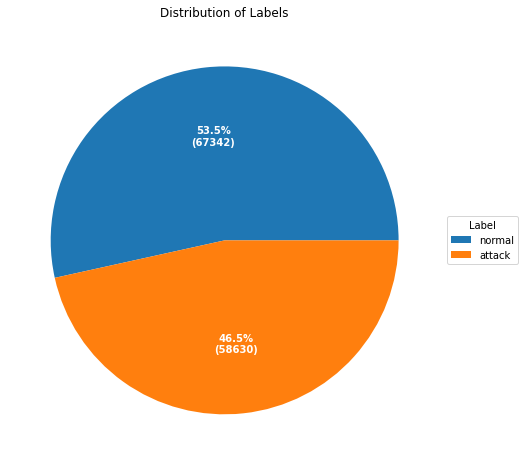

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, lab,
          title="Label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Distribution of Labels")

plt.show()

Now we move on to the distribution of the 4 classes of attacks.

In [ ]:
DOS = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','upstorm','worm']
Probe = ['ipsweep','nmap','mscan','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','Snmpgetattack','spy','snmpguess','warzclient','warzmaster','xlock','xsnoop']
count = {'DOS':0, 'Probe':0, 'U2R':0, 'R2L':0}
for attack in train.attack:
    if attack in DOS:
        count['DOS'] += 1
    elif attack in Probe:
        count['Probe'] += 1
    elif attack in U2R:
        count['U2R'] += 1
    elif attack in R2L:
        count['R2L'] += 1
count

{'DOS': 45927, 'Probe': 11656, 'R2L': 85, 'U2R': 52}

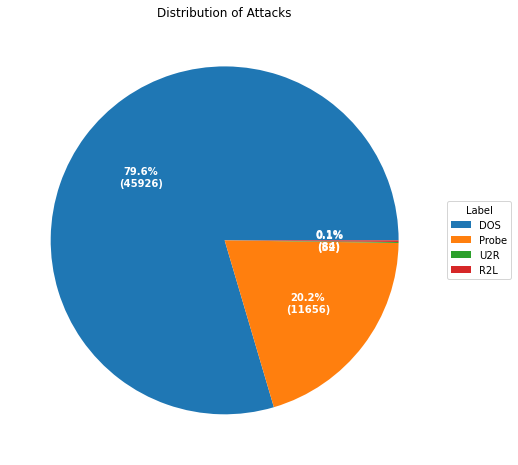

[45927, 11656, 52, 85]

In [ ]:
data = list(count.values())
lab = list(count.keys())
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, lab,
          title="Label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("Distribution of Attacks")

plt.show()
data

Column 42, specifies the severity of the attack. For the intrusion detection system, the severity of an attack is irrelevant as any attack can be sever. It does not help in classifying whether there was an attack or not, or which type of attack was observed. Thus the column 42 is removed from the data.<br>

Initially, the model is supposed to detect whether there has been an attack or not (detection). Only then should it learn to classify the attacks. Thus the column 41 is removed for the initial model.

In [ ]:
train.drop(train.iloc[:, 41:45], inplace = True, axis = 1)
test.drop(test.iloc[:, 41:45], inplace = True, axis = 1)
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1


In [ ]:
categorical = [1,2,3]

encoder = LabelEncoder()
for col in categorical:
    train.iloc[:,col] = pd.Series(encoder.fit_transform(train.iloc[:,col]))
    test.iloc[:,col] = pd.Series(encoder.transform(test.iloc[:,col]))
    

In [ ]:
train = pd.concat([train,test],axis=0)

X = train.drop(columns='target',axis=1)
y = train.target

scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X))

X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,random_state=10)

All the columns that are textual i.e. strings, are encoded to numerics for the understanding of the model. Since all the models applied cannot inherently handle textual data. A `LabelEncoder` is fit on the train data. The same encodings are used for the test data as well to maintain uniformity.

As shown previously, the test set contains types of attacks which are not in the train set. Every attack has a different kind of signature. The model can learn the signature of a type of an attack and can thus detect it in future. But for those attacks whose signatures are not known might not always be detected by the model. To avoid such an issue, the two sets are combined and then randomly split into train and test set again.<br>

The train set will be used to train the model and test set for testing the model on unseen data.

The following are the models which will be trained and compared for the intrusion detection problem statement.
  * Decision Tree
  * Random Forest classifier
  * Support Vector Machines
  * Logistic Regression
  * Gaussian Naive Bayes
  * Multi-Layer Perceptron classifier
  


##Decision Tree


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)

clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)

print("Train score: ",clf.score(X_train, y_train))

pred_dt = clf.predict(X_test)
print('Test score:',clf.score(X_test, y_test))

print("Classification report: ",classification_report(pred_dt,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_dt))
print("Average weighted recall: ",recall_score(y_test,pred_dt))
print("Average weighted f1 score: ",f1_score(y_test,pred_dt))

Train score:  0.9816944526740105
Test score: 0.9801508214381901
Classification report:                precision    recall  f1-score   support

           0       0.99      0.97      0.98     19631
           1       0.97      0.99      0.98     17499

    accuracy                           0.98     37130
   macro avg       0.98      0.98      0.98     37130
weighted avg       0.98      0.98      0.98     37130

Average weighted precision:  0.9903994513972227
Average weighted recall:  0.9682122905027933
Average weighted f1 score:  0.9791802028305885


## Random Forest

The Random Forest model, an ensemble technique, tackles the bias and overfitting a Decision Tree classifier is exposed to by fitting a forest (n_estimators i.e. large number) of Decision trees on the data, each fit on a random subset of data. It then aggregates the votes and outputs the final classification.

In [ ]:
rf_mod = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state= 10, verbose= 1)
rf_mod.fit(X_train, y_train)

print("Train score: ",rf_mod.score(X_train, y_train))

pred_rf = rf_mod.predict(X_test)
print('Test score:',rf_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_rf,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_rf))
print("Average weighted recall: ",recall_score(y_test,pred_rf))
print("Average weighted f1 score: ",f1_score(y_test,pred_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train score:  0.9994703152073402


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test score: 0.9954214920549421
Classification report:                precision    recall  f1-score   support

           0       1.00      0.99      1.00     19264
           1       0.99      1.00      1.00     17866

    accuracy                           1.00     37130
   macro avg       1.00      1.00      1.00     37130
weighted avg       1.00      1.00      1.00     37130

Average weighted precision:  0.9961938878316355
Average weighted recall:  0.9943016759776536
Average weighted f1 score:  0.9952468825141195


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


## Support Vector Machine

The objective of the support vector machine is to find a Hyper-plane in an N-dimensional feature space, which distinctly classifies the target. The hyper-plane chosen is such that it has maximum margin, i.e. it has maximum distance from all the two classes. This gives enough room for future unseen data to be classified correctly.

In [ ]:
svm_mod = SVC(probability=True)
svm_mod.fit(X_train, y_train)

print("Train score: ",svm_mod.score(X_train, y_train))

pred_svc = svm_mod.predict(X_test)
print('Test score:',svm_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_svc,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_svc))
print("Average weighted recall: ",recall_score(y_test,pred_svc))
print("Average weighted f1 score: ",f1_score(y_test,pred_svc))

Train score:  0.9836875039277474
Test score: 0.9828709938055481
Classification report:                precision    recall  f1-score   support

           0       0.99      0.98      0.98     19410
           1       0.98      0.99      0.98     17720

    accuracy                           0.98     37130
   macro avg       0.98      0.98      0.98     37130
weighted avg       0.98      0.98      0.98     37130

Average weighted precision:  0.9871331828442438
Average weighted recall:  0.9772067039106145
Average weighted f1 score:  0.9821448624368333


## Gaussian Naive Bayes

Naive Bayes is a simple algorthim, that can predict the relative probability of a target class and thus classify them. It uses the Bayes theorem to calculate the probability of an input data point belonging to a target class [ P(target class|input) ]. It assumes there exist no correlation between the features and thus is Naive.

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(X_train, y_train)

print("Train score: ",gnb_mod.score(X_train, y_train))

pred_nb = gnb_mod.predict(X_test)
print('Test score:',gnb_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_nb,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_nb))
print("Average weighted recall: ",recall_score(y_test,pred_nb))
print("Average weighted f1 score: ",f1_score(y_test,pred_nb))

Train score:  0.8799680393582734
Test score: 0.8808241314301104
Classification report:                precision    recall  f1-score   support

           0       0.89      0.88      0.89     19399
           1       0.87      0.88      0.88     17731

    accuracy                           0.88     37130
   macro avg       0.88      0.88      0.88     37130
weighted avg       0.88      0.88      0.88     37130

Average weighted precision:  0.87998420844848
Average weighted recall:  0.8716759776536313
Average weighted f1 score:  0.8758103898290813


## Logistic Regression

Logistic regression applies Linear regression on the data by fitting an equation of similar kind. The predictions are trasnformed by the sigmoid function, which restricts the value between 0 and 1. If the output is a value larger than 0.5, the classifier outputs a 1, otherwise a 0.

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(X_train, y_train)

print("Train score: ",lg_mod.score(X_train, y_train))

pred_lg = lg_mod.predict(X_test)
print('Test score:',lg_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_lg,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_lg))
print("Average weighted recall: ",recall_score(y_test,pred_lg))
print("Average weighted f1 score: ",f1_score(y_test,pred_lg))

Train score:  0.9361954267553664
Test score: 0.9373552383517372
Classification report:                precision    recall  f1-score   support

           0       0.96      0.93      0.94     19840
           1       0.92      0.95      0.93     17290

    accuracy                           0.94     37130
   macro avg       0.94      0.94      0.94     37130
weighted avg       0.94      0.94      0.94     37130

Average weighted precision:  0.9503759398496241
Average weighted recall:  0.9179888268156424
Average weighted f1 score:  0.9339016766126741


## Multi-Layer Perceptron

A Multi-Layer Perceptron classifier is a neural network classifier that applies the Error Back Propogation Training (EBPT) algorithm to learn weights for the network that suitably classify the input pattern space to target classes.

In [ ]:
mlp_mod = MLPClassifier(hidden_layer_sizes=[100,50])
mlp_mod.fit(X_train, y_train)

print("Train score: ",mlp_mod.score(X_train, y_train))

pred_mlp = mlp_mod.predict(X_test)
print('Test score:',mlp_mod.score(X_test, y_test))

print("Classification report: ",classification_report(pred_mlp,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_mlp))
print("Average weighted recall: ",recall_score(y_test,pred_mlp))
print("Average weighted f1 score: ",f1_score(y_test,pred_mlp))

Train score:  0.9944248431145466
Test score: 0.9908968489092378
Classification report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99     19066
           1       1.00      0.99      0.99     18064

    accuracy                           0.99     37130
   macro avg       0.99      0.99      0.99     37130
weighted avg       0.99      0.99      0.99     37130

Average weighted precision:  0.9861049601417183
Average weighted recall:  0.9951396648044692
Average weighted f1 score:  0.990601712823935


## Model Comparision

All the 6 models show good accuracy, precision, recall and f1 scores on the test set. The models are said to have trained well and show a good fit. To evaluate these models, the ROC curve and Calibration plots have been ploted below.<br>

The ROC curve, shows the True Positive rates vs the False positive rates for the model. The closer the area under the curve is to a 1, the better the model trained is. The reference is a no skill model, which predicts only one class all the time and has an area under the curve of 0.5

No Skill AUC:  0.5
DecisionTree AUC:  0.9930326015275248


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished


RandomForest AUC:  0.999834521537286
Support Vector Machine AUC:  0.9973158400079022
Logistic Regression AUC:  0.9821765238207294
Gaussian Naive Bayes AUC:  0.9420016065447085
MultiLayer Perceptron AUC:  0.9993724699825982


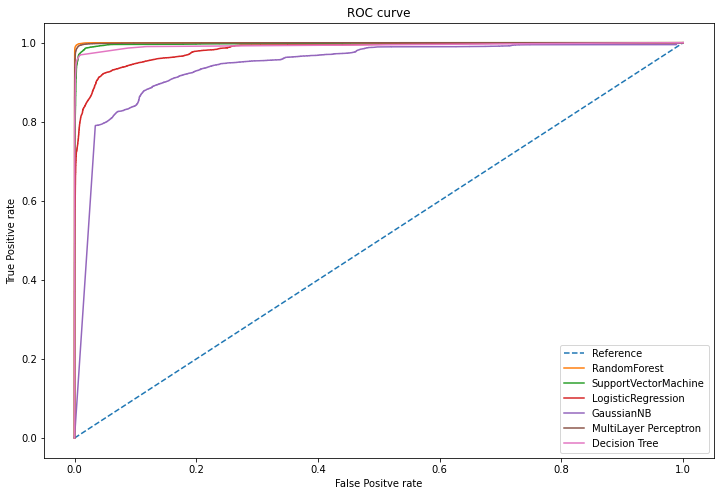

In [ ]:
no_skill_prob = [0 for _ in range(len(y_test))]
no_skill_auc = roc_auc_score(y_test, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_prob)

dt_prob = clf.predict_proba(X_test)[:,-1]
dt_auc = roc_auc_score(y_test,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)

rf_prob = rf_mod.predict_proba(X_test)[:,-1]
rf_auc = roc_auc_score(y_test,rf_prob)
print("RandomForest AUC: ", rf_auc)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)

svm_prob = svm_mod.predict_proba(X_test)[:,-1]
svm_auc = roc_auc_score(y_test,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

lg_prob = lg_mod.predict_proba(X_test)[:,-1]
lg_auc = roc_auc_score(y_test, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(y_test, lg_prob)

nb_prob = gnb_mod.predict_proba(X_test)[:,-1]
nb_auc = roc_auc_score(y_test, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_prob)


mlp_prob = mlp_mod.predict_proba(X_test)[:,-1]
mlp_auc = roc_auc_score(y_test, mlp_prob)
print("MultiLayer Perceptron AUC: ", mlp_auc)
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_prob)

fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(mlp_fpr, mlp_tpr, linestyle='-', label= 'MultiLayer Perceptron')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')
ax.legend(loc="bottom right")

The below plot is a zoomed in version of the ROC curve plot, to clearly distinguish between the models.

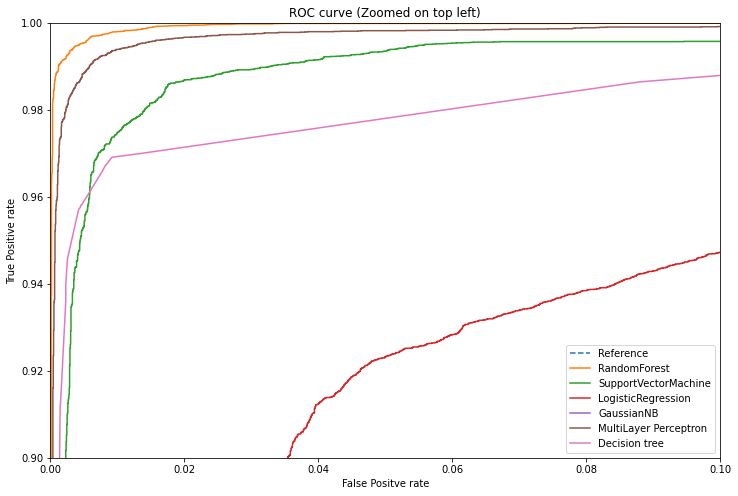

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(rf_fpr, rf_tpr, linestyle= '-', label= 'RandomForest')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(mlp_fpr, mlp_tpr, linestyle='-', label= 'MultiLayer Perceptron')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision tree')
plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve (Zoomed on top left)')
plt.xlim([0,0.1])
plt.ylim([0.9,1])
ax.legend(loc="bottom right")

A reliability diagram is a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency (x-axis). The predicted probabilites are divided into fixed number of buckets (bins). The more reliable predictions are, the closer they are to being on the line y=x

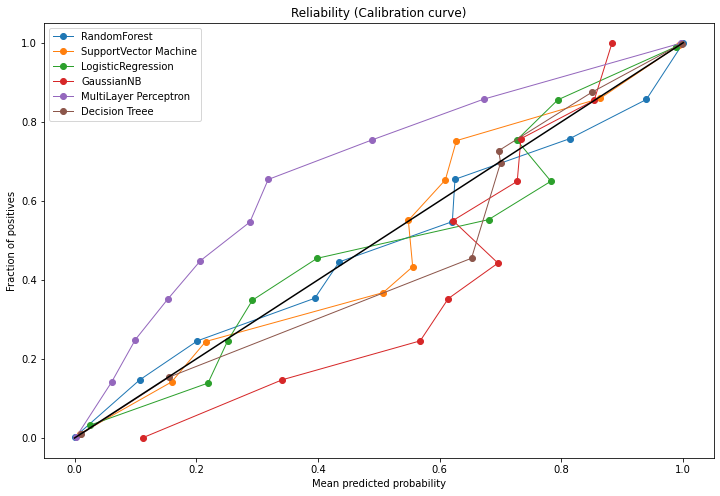

In [ ]:
rf_x, rf_y = calibration_curve(y_test, rf_prob, n_bins=10)
sv_x, sv_y = calibration_curve(y_test, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(y_test, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(y_test, nb_prob, n_bins=10)
mlp_x, mlp_y = calibration_curve(y_test, mlp_prob, n_bins=10)
dt_x, dt_y = calibration_curve(y_test,dt_prob,n_bins=10)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rf_x, rf_y, marker= 'o', linewidth= '1', label= 'RandomForest')
ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(mlp_x, mlp_y, marker= 'o', linewidth= '1', label= 'MultiLayer Perceptron')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Treee')

line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

The table below tabulates all the scores from each model for a clear comparision.

In [ ]:
models = {
    'Random Forest':rf_mod, 
    'Support Vector Machine': svm_mod,
    'Logistic Regression':lg_mod,
    'Gaussian Naive Bayes': gnb_mod,
    'Multi-Layer Perceptron':mlp_mod,
    'Decision tree':clf
}

columns = [
    'accuracy',
    'precision',
    'recall',
    'f1'
]

table = {}


for model in models.keys():
    
    pred = models[model].predict(X_test)
    accuracy = models[model].score(X_test,y_test)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    
    table[model] = [accuracy, precision, recall, f1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


In [ ]:
results = pd.DataFrame.from_dict(table, orient='index')
results.columns = columns
results

,accuracy,precision,recall,f1
Random Forest,0.995421,0.996194,0.994302,0.995247
Support Vector Machine,0.982871,0.987133,0.977207,0.982145
Logistic Regression,0.937355,0.950376,0.917989,0.933902
Gaussian Naive Bayes,0.880824,0.879984,0.871676,0.875810
Multi-Layer Perceptron,0.990897,0.986105,0.995140,0.990602
Decision tree,0.980151,0.990399,0.968212,0.979180


## Inference

After training all the six models, listed below:- 

* Random Forest
* Decision Tree
* Support Vector Machine
* Logistic Regression
* Gaussian Naive Bayes
* Multi-Layer Perceptron

From these trained models, the results table shows the Random Forest and Multi-Layer Perceptron classifiers boast a 99% accuracy, precision, recall and f1 scores. The Support Vector machine is not far behind with a 98%.<br>
The ROC curve shows, similar results that these three models - Random Forest and Multi-Layer Perceptron have about 0.99 area under the curve. The Random Forest among these three has the highest Area under the curve.<br>
The Reliability diagram (Calibration curve) shows that Random Forest classifier mimic the diagonal (y=x) line the most and hence tend to output reliable predictions. The Multi-Perceptron classifier until now showed at par results, but the calibration curve shows that its way off as compared to the other two and hence the predictions from this model are not reliable.<br>

In conclusion, the Random Forest classifier out performs all the models in detecting intrusion on the network.


In [ ]:
dt_prob = clf.predict_proba(X_test)[:,-1]
rf_prob = rf_mod.predict_proba(X_test)[:,-1]
svm_prob = svm_mod.predict_proba(X_test)[:,-1]
lg_prob = lg_mod.predict_proba(X_test)[:,-1]
gnb_prob = gnb_mod.predict_proba(X_test)[:,-1]
mlp_prob = mlp_mod.predict_proba(X_test)[:,-1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.8s finished


In [ ]:
print(dt_prob)
finalpred= (dt_prob+rf_prob+svm_prob+lg_prob+nb_prob+mlp_prob)/6
print(finalpred)

[0.990052   0.9992407  0.00984766 ... 0.0244898  0.00984766 0.99983616]
[0.99378221 0.81136991 0.00342949 ... 0.01190216 0.00635459 0.99993378]
